# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import multiprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow as tf
import tensorflow
from tensorflow.keras.utils import to_categorical
import pickle
import catboost as cb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)

# Set Random State

In [2]:
global rand_state
rand_state = 2023

# Utility Functions

In [3]:
def get_mean_cvs(model, X, y, fit_params=None):
    global rand_state
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='neg_log_loss',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise', 
                             fit_params=fit_params)
    
    print(f'Cross Validation Negative Logloss Score: {scores.mean():.3f} ({scores.std():.3f})')
    
    return scores


def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                labels=labels, 
                                digits=3))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3, 
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None, 
                                 scoring='accuracy', 
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'{mean} ({stdev}) with: {param}')
    print("Best Parameters: " +  str(grid_result.best_params_))
        
    return grid_result

# Load Dataset

In [4]:
X_train = pd.read_csv('./dataset/SmartLocal/X_train.csv')
y_train = pd.read_csv('./dataset/SmartLocal/y_train.csv').to_numpy().ravel()

X_test = pd.read_csv('./dataset/SmartLocal/X_test.csv')
y_test = pd.read_csv('./dataset/SmartLocal/y_test.csv').to_numpy().ravel()

In [5]:
X_train_tree = pd.read_csv('./dataset/SmartLocal/X_train_tree.csv')
y_train_tree = pd.read_csv('./dataset/SmartLocal/y_train_tree.csv').to_numpy().ravel()

X_test_tree = pd.read_csv('./dataset/SmartLocal/X_test_tree.csv')
y_test_tree = pd.read_csv('./dataset/SmartLocal/y_test_tree.csv').to_numpy().ravel()

In [6]:
categorical_cols = X_train_tree.select_dtypes(include='O').keys().tolist()

label_encoder = LabelEncoder()

for col in categorical_cols:
    X_train_tree[col] = label_encoder.fit_transform(X_train_tree[col].astype(str))
    X_test_tree[col] = label_encoder.fit_transform(X_test_tree[col].astype(str))

# Scaling Data

In [7]:
# Gradient descent and distance-based algorithms require feature scaling while tree-based algorithms do not.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Probabilistic

## Logistic Regression

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Negative Logloss Score: -1.005 (0.026)
                precision    recall  f1-score   support

   High Shares      0.516     0.580     0.546       245
Average Shares      0.420     0.325     0.367       283
    Low Shares      0.505     0.568     0.535       271

      accuracy                          0.486       799
     macro avg      0.480     0.491     0.482       799
  weighted avg      0.478     0.486     0.479       799



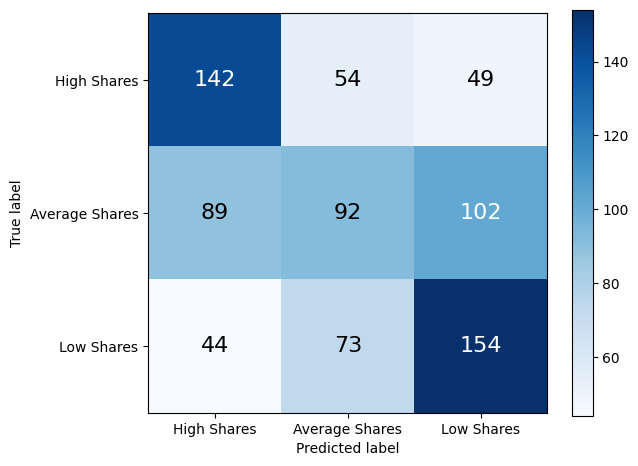

In [8]:
lr_base_model = LogisticRegression(max_iter=1000, random_state=rand_state)
print(lr_base_model.get_params())

get_mean_cvs(lr_base_model, X_train_scaled, y_train)

lr_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = lr_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Negative Logloss Score: -1.004 (0.026)
                precision    recall  f1-score   support

   High Shares      0.513     0.584     0.546       245
Average Shares      0.399     0.300     0.343       283
    Low Shares      0.498     0.565     0.529       271

      accuracy                          0.477       799
     macro avg      0.470     0.483     0.473       799
  weighted avg      0.468     0.477     0.468       799



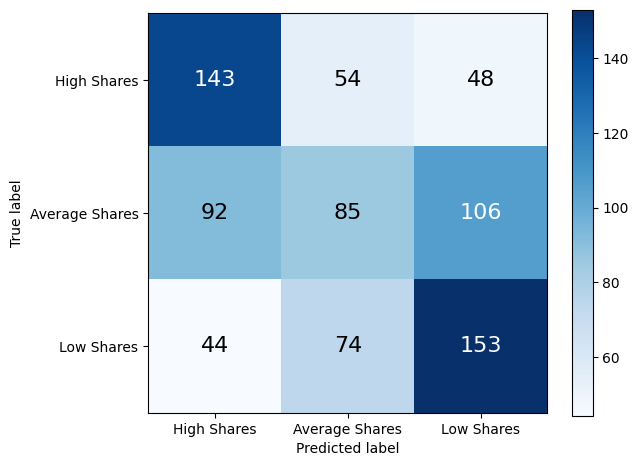

In [9]:
lr_GS = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=rand_state), 
    {
        'C': [0.1, 1, 10], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lr_GS = lr_GS.fit(X_train_scaled, y_train)

lr_best_model = lr_GS.best_estimator_
print(lr_best_model.get_params())

get_mean_cvs(lr_best_model, X_train_scaled, y_train)

lr_best_model.fit(X_train_scaled, y_train)
y_pred_lr_best = lr_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [10]:
pickle.dump(lr_best_model, open('./dataset/Model/lr_best_model.pkl', 'wb'))

## Naive Bayes

{'priors': None, 'var_smoothing': 1e-09}
Cross Validation Negative Logloss Score: -5.586 (0.301)


C:\Users\user\anaconda3\envs\is4242\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

   High Shares      0.323     0.980     0.486       245
Average Shares      0.000     0.000     0.000       283
    Low Shares      0.579     0.122     0.201       271

      accuracy                          0.342       799
     macro avg      0.301     0.367     0.229       799
  weighted avg      0.296     0.342     0.217       799



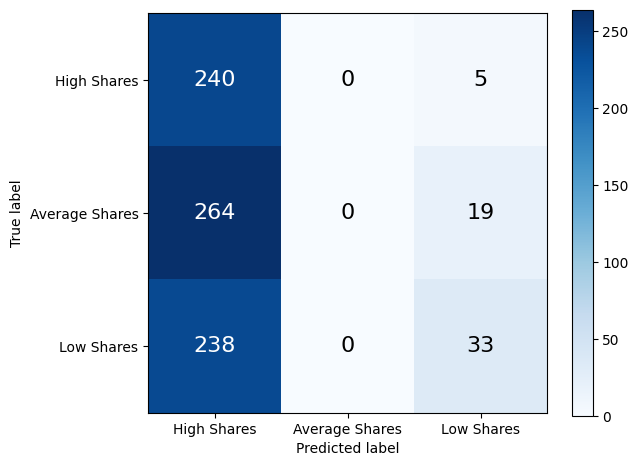

In [11]:
nb_base_model = GaussianNB()
print(nb_base_model.get_params())

get_mean_cvs(nb_base_model, X_train_scaled, y_train)

nb_base_model.fit(X_train_scaled, y_train)
y_pred_nb_base = nb_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_nb_base)

{'priors': None, 'var_smoothing': 0.01}
Cross Validation Negative Logloss Score: -2.243 (0.290)
                precision    recall  f1-score   support

   High Shares      0.513     0.584     0.546       245
Average Shares      0.399     0.300     0.343       283
    Low Shares      0.498     0.565     0.529       271

      accuracy                          0.477       799
     macro avg      0.470     0.483     0.473       799
  weighted avg      0.468     0.477     0.468       799



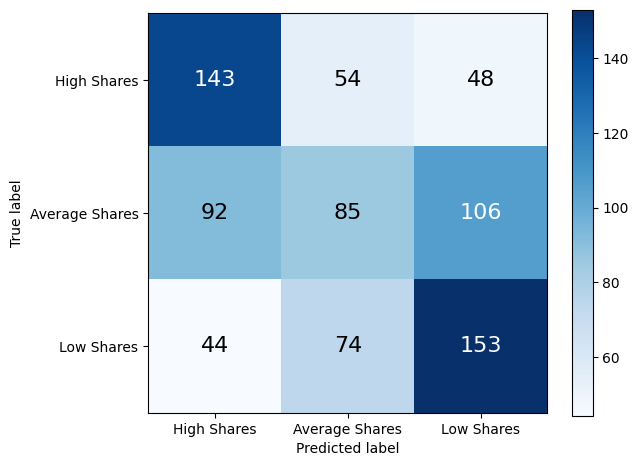

In [12]:
nb_GS = GridSearchCV(
    GaussianNB(), 
    {
        'var_smoothing': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
    }, 
    n_jobs=multiprocessing.cpu_count())

nb_GS = nb_GS.fit(X_train_scaled, y_train)

nb_best_model = nb_GS.best_estimator_
print(nb_best_model.get_params())

get_mean_cvs(nb_best_model, X_train_scaled, y_train)

nb_best_model.fit(X_train_scaled, y_train)
y_pred_nb_best = nb_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [13]:
pickle.dump(nb_best_model, open('./dataset/Model/nb_best_model.pkl', 'wb'))

# Instance Based

## K-Nearest Neighbours

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Cross Validation Negative Logloss Score: -4.777 (0.649)
                precision    recall  f1-score   support

   High Shares      0.442     0.416     0.429       245
Average Shares      0.411     0.544     0.468       283
    Low Shares      0.513     0.365     0.427       271

      accuracy                          0.444       799
     macro avg      0.455     0.442     0.441       799
  weighted avg      0.455     0.444     0.442       799



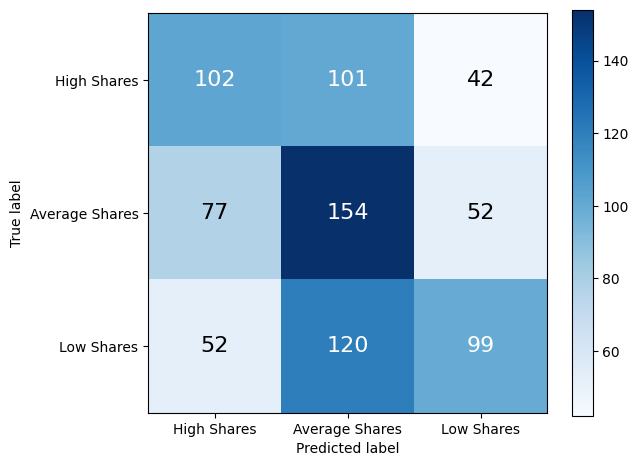

In [14]:
knn_base_model = KNeighborsClassifier()
print(knn_base_model.get_params())

get_mean_cvs(knn_base_model, X_train_scaled, y_train)

knn_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = knn_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
Cross Validation Negative Logloss Score: -1.880 (0.312)
                precision    recall  f1-score   support

   High Shares      0.456     0.469     0.463       245
Average Shares      0.433     0.435     0.434       283
    Low Shares      0.475     0.461     0.468       271

      accuracy                          0.454       799
     macro avg      0.455     0.455     0.455       799
  weighted avg      0.455     0.454     0.454       799



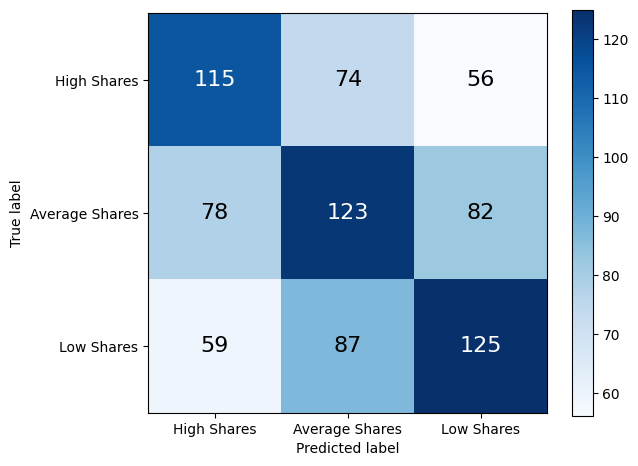

In [15]:
knn_GS = GridSearchCV(
    KNeighborsClassifier(), 
    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30],
        'p': [1, 2, 3]
    }, 
    n_jobs=multiprocessing.cpu_count())

knn_GS = knn_GS.fit(X_train_scaled, y_train)

knn_best_model = knn_GS.best_estimator_
print(knn_best_model.get_params())

get_mean_cvs(knn_best_model, X_train_scaled, y_train)

knn_best_model.fit(X_train_scaled, y_train)
y_pred_knn_best = knn_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_knn_best)

In [16]:
pickle.dump(knn_best_model, open('./dataset/Model/knn_best_model.pkl', 'wb'))

## Support Vector Machine

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Negative Logloss Score: -1.017 (0.019)
                precision    recall  f1-score   support

   High Shares      0.505     0.567     0.535       245
Average Shares      0.407     0.332     0.366       283
    Low Shares      0.495     0.535     0.514       271

      accuracy                          0.473       799
     macro avg      0.469     0.478     0.472       799
  weighted avg      0.467     0.473     0.468       799



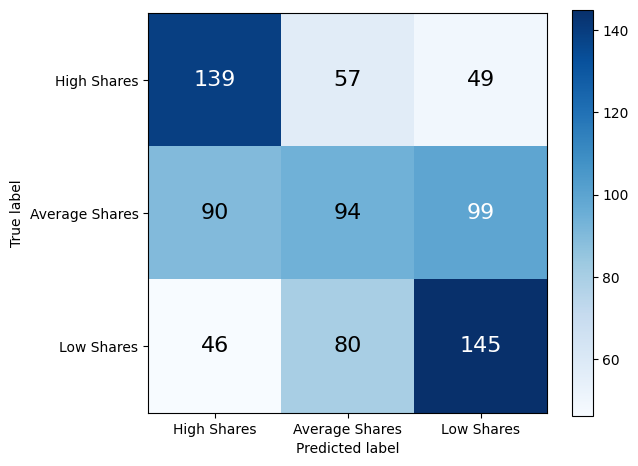

In [18]:
svm_base_model = SVC(probability=True)
print(svm_base_model.get_params())

get_mean_cvs(svm_base_model, X_train_scaled, y_train)

svm_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = svm_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Negative Logloss Score: -1.003 (0.023)
                precision    recall  f1-score   support

   High Shares      0.520     0.576     0.547       245
Average Shares      0.417     0.300     0.349       283
    Low Shares      0.503     0.601     0.548       271

      accuracy                          0.487       799
     macro avg      0.480     0.492     0.481       799
  weighted avg      0.478     0.487     0.477       799



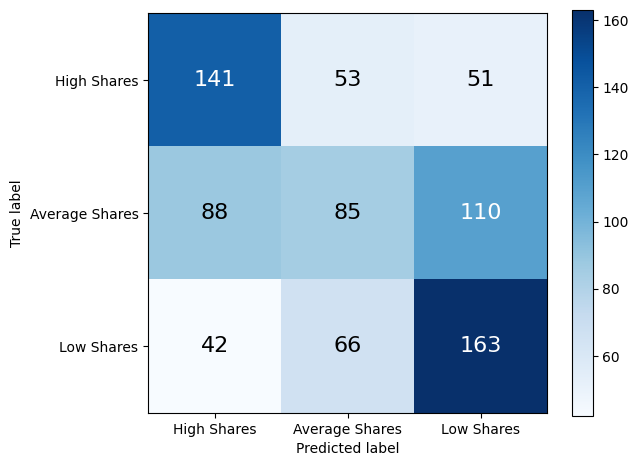

In [20]:
svm_GS = GridSearchCV(
    SVC(probability=True), 
    {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto', 0.1, 1]
    }, 
    n_jobs=multiprocessing.cpu_count())

svm_GS = svm_GS.fit(X_train_scaled, y_train)

svm_best_model = svm_GS.best_estimator_
print(svm_best_model.get_params())

get_mean_cvs(svm_best_model, X_train_scaled, y_train)

svm_best_model.fit(X_train_scaled, y_train)
y_pred_svm_best = svm_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svm_best)

In [21]:
pickle.dump(svm_best_model, open('./dataset/Model/svm_best_model.pkl', 'wb'))

# Tree Based

## Random Forest

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2023, 'verbose': 0, 'warm_start': False}
Cross Validation Negative Logloss Score: -1.014 (0.020)
                precision    recall  f1-score   support

   High Shares      0.496     0.547     0.520       245
Average Shares      0.394     0.346     0.368       283
    Low Shares      0.511     0.528     0.519       271

      accuracy                          0.469       799
     macro avg      0.467     0.474     0.469       799
  weighted avg      0.465     0.469     0.466       799



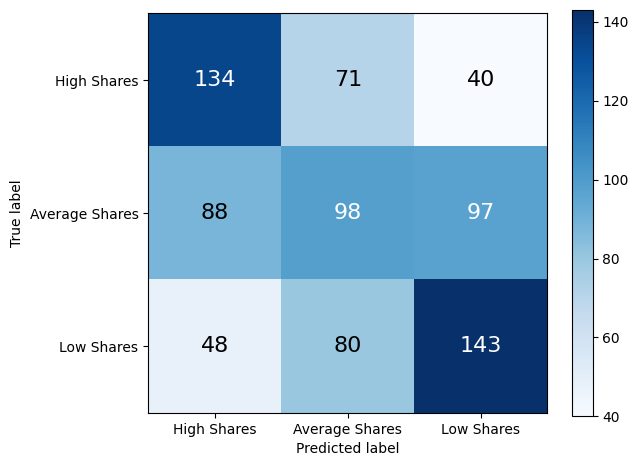

In [22]:
rf_base_model = RandomForestClassifier(
    random_state=rand_state, 
)
print(rf_base_model.get_params())

get_mean_cvs(rf_base_model, X_train, y_train)

rf_base_model.fit(X_train, y_train)
y_pred_cb_base = rf_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=2023)
Cross Validation Negative Logloss Score: -1.007 (0.020)
                precision    recall  f1-score   support

   High Shares      0.486     0.547     0.514       245
Average Shares      0.350     0.265     0.302       283
    Low Shares      0.489     0.557     0.521       271

      accuracy                          0.451       799
     macro avg      0.442     0.456     0.446       799
  weighted avg      0.439     0.451     0.441       799



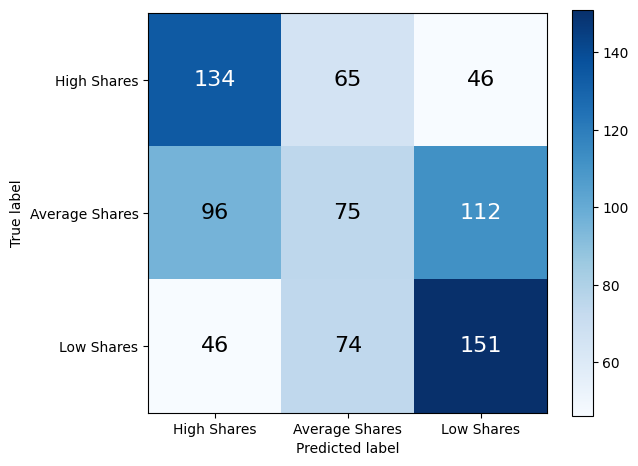

In [23]:
rf_GS = GridSearchCV(
    RandomForestClassifier(random_state=rand_state), 
    {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }, 
    n_jobs=multiprocessing.cpu_count())

rf_GS = rf_GS.fit(X_train, y_train)

rf_best_model = rf_GS.best_estimator_
print(rf_best_model)

get_mean_cvs(rf_best_model, X_train, y_train)

rf_best_model.fit(X_train, y_train)
y_pred_rf_best = rf_best_model.predict(X_test)
evaluate_model(y_test, y_pred_rf_best)

In [24]:
pickle.dump(rf_best_model, open('./dataset/Model/rf_best_model.pkl', 'wb'))

## CatBoost

{'verbose': False, 'allow_writing_files': False, 'random_state': 2023, 'objective': 'MultiClass', 'cat_features': ['category', 'subcategory1', 'author', 'author_category']}
Cross Validation Negative Logloss Score: -1.049 (0.040)
                precision    recall  f1-score   support

   High Shares      0.476     0.453     0.464       245
Average Shares      0.397     0.346     0.370       283
    Low Shares      0.467     0.550     0.505       271

      accuracy                          0.448       799
     macro avg      0.447     0.450     0.446       799
  weighted avg      0.445     0.448     0.445       799



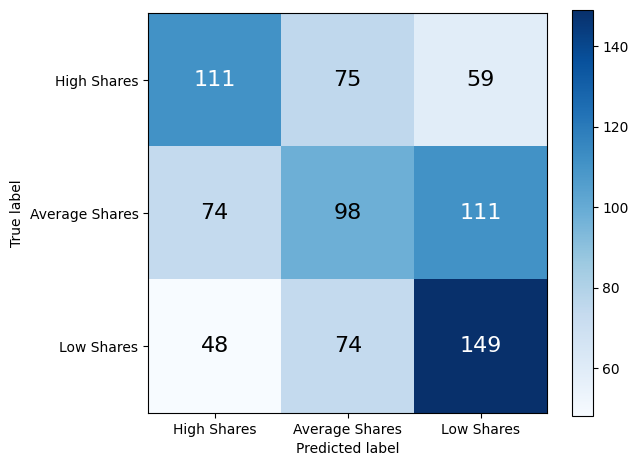

In [25]:
cb_base_model = cb.CatBoostClassifier(
    objective='MultiClass',
    cat_features=categorical_cols,
    allow_writing_files=False,
    random_state=rand_state,
    verbose=False
)
print(cb_base_model.get_params())

get_mean_cvs(cb_base_model, X_train_tree, y_train_tree)

cb_base_model.fit(X_train_tree, y_train_tree, verbose=False)
y_pred_cb_base = cb_base_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_cb_base)

{'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3, 'verbose': False, 'n_estimators': 60, 'random_state': 2023, 'objective': 'MultiClass', 'cat_features': ['category', 'subcategory1', 'author', 'author_category']}
Cross Validation Negative Logloss Score: -0.994 (0.019)
                precision    recall  f1-score   support

   High Shares      0.467     0.376     0.416       245
Average Shares      0.414     0.339     0.373       283
    Low Shares      0.446     0.609     0.515       271

      accuracy                          0.442       799
     macro avg      0.442     0.441     0.435       799
  weighted avg      0.441     0.442     0.434       799



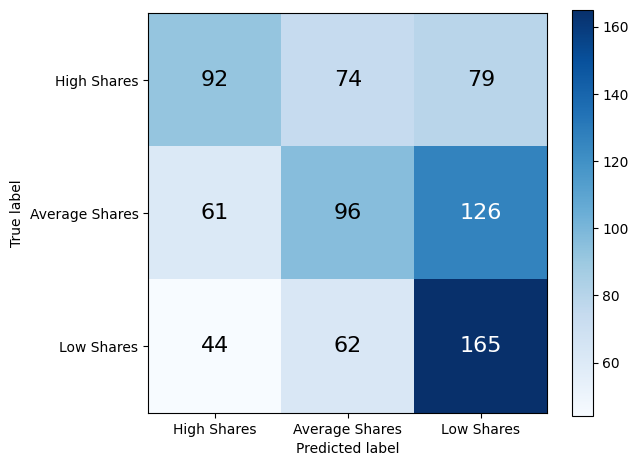

In [26]:
cb_GS = GridSearchCV(
    cb.CatBoostClassifier(objective='MultiClass', cat_features=categorical_cols, random_state=rand_state, verbose=False), 
    {
        'depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'l2_leaf_reg': [1, 3, 5],
    }, 
    n_jobs=multiprocessing.cpu_count())

cb_GS = cb_GS.fit(X_train_tree, y_train_tree)

cb_best_model = cb_GS.best_estimator_
print(cb_best_model.get_params())

get_mean_cvs(cb_best_model, X_train_tree, y_train_tree)

cb_best_model.fit(X_train_tree, y_train_tree)
y_pred_cb_best = cb_best_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_cb_best)

In [27]:
pickle.dump(cb_best_model, open('./dataset/Model/cb_best_model.pkl', 'wb'))

## LightGBM

LGBMClassifier(categorical_feature=['category', 'subcategory1', 'author',
                                    'author_category'],
               objective='accuracy', random_state=2023)
Cross Validation Negative Logloss Score: -1.078 (0.041)


C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


                precision    recall  f1-score   support

   High Shares      0.432     0.388     0.409       245
Average Shares      0.397     0.293     0.337       283
    Low Shares      0.451     0.616     0.521       271

      accuracy                          0.432       799
     macro avg      0.427     0.432     0.422       799
  weighted avg      0.426     0.432     0.422       799



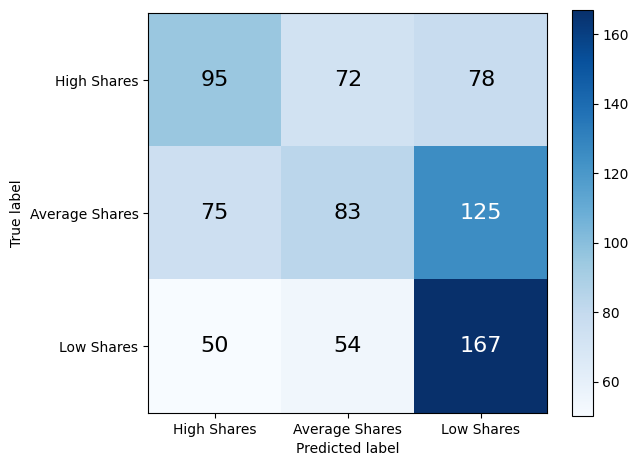

In [29]:
lgb_base_model = lgb.LGBMClassifier(
    objective='accuracy',
    categorical_feature=categorical_cols,
    random_state=rand_state
)
print(lgb_base_model)

get_mean_cvs(lgb_base_model, X_train_tree, y_train_tree, fit_params={'categorical_feature': categorical_cols})

lgb_base_model.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)
y_pred_lgb_base = lgb_base_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_lgb_base)

C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_feature=['category', 'subcategory1', 'author',
                                    'author_category'],
               learning_rate=0.01, max_depth=10, n_estimators=140,
               num_leaves=10, objective='accuracy', random_state=2023,
               subsample=0.5)
Cross Validation Negative Logloss Score: -1.005 (0.018)


C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


                precision    recall  f1-score   support

   High Shares      0.419     0.420     0.420       245
Average Shares      0.355     0.194     0.251       283
    Low Shares      0.432     0.635     0.514       271

      accuracy                          0.413       799
     macro avg      0.402     0.416     0.395       799
  weighted avg      0.401     0.413     0.392       799



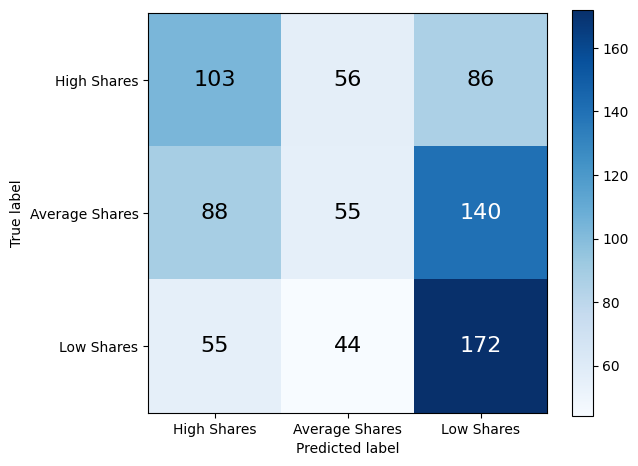

In [30]:
lgb_GS = GridSearchCV(
    lgb.LGBMClassifier(objective='accuracy', categorical_feature=categorical_cols, random_state=rand_state), 
    {
        'max_depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 0.9], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lgb_GS = lgb_GS.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)

lgb_best_model = lgb_GS.best_estimator_
print(lgb_best_model)

get_mean_cvs(lgb_best_model, X_train_tree, y_train_tree, fit_params={'categorical_feature': categorical_cols})

lgb_best_model.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)
y_pred_lgb_best = lgb_best_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_lgb_best)

In [31]:
pickle.dump(lgb_best_model, open('./dataset/Model/lgb_best_model.pkl', 'wb'))

## Adaboost

AdaBoostClassifier(random_state=2023)
Cross Validation Negative Logloss Score: -1.091 (0.002)
                precision    recall  f1-score   support

   High Shares      0.470     0.551     0.508       245
Average Shares      0.358     0.276     0.311       283
    Low Shares      0.514     0.557     0.535       271

      accuracy                          0.456       799
     macro avg      0.447     0.461     0.451       799
  weighted avg      0.445     0.456     0.447       799



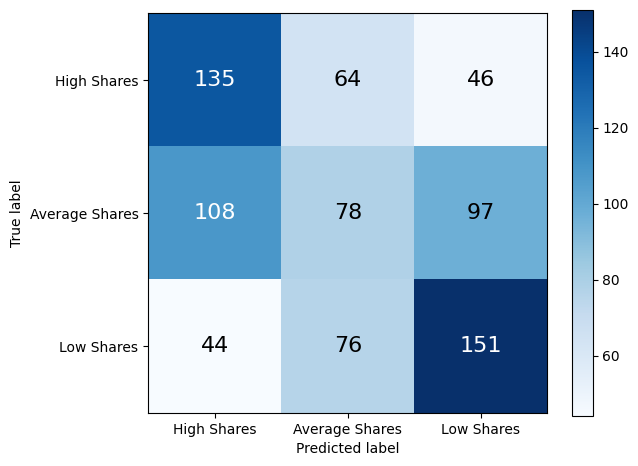

In [32]:
ada_base_model = AdaBoostClassifier(
    random_state=rand_state
)
print(ada_base_model)

get_mean_cvs(ada_base_model, X_train, y_train)

ada_base_model.fit(X_train, y_train)
y_pred_lgb_base = ada_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=2023)
Cross Validation Negative Logloss Score: -1.082 (0.002)
                precision    recall  f1-score   support

   High Shares      0.515     0.563     0.538       245
Average Shares      0.363     0.244     0.292       283
    Low Shares      0.457     0.576     0.510       271

      accuracy                          0.454       799
     macro avg      0.445     0.461     0.447       799
  weighted avg      0.442     0.454     0.441       799



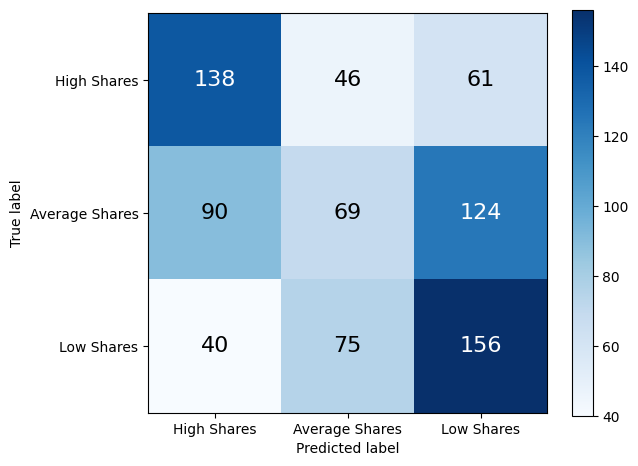

In [35]:
ada_GS = GridSearchCV(
    AdaBoostClassifier(random_state=rand_state), 
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }, 
    n_jobs=multiprocessing.cpu_count())

ada_GS = ada_GS.fit(X_train, y_train)

ada_best_model = ada_GS.best_estimator_
print(ada_best_model)

get_mean_cvs(ada_best_model, X_train, y_train)

ada_best_model.fit(X_train, y_train)
y_pred_ada_best = ada_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ada_best)

In [36]:
pickle.dump(ada_best_model, open('./dataset/Model/ada_best_model.pkl', 'wb'))

# Deep Learning

In [37]:
# Reshape X_train and X_test
X_train_map = np.reshape(X_train_scaled.values, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_map = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Map y_train and y_test
mapper = {'Low Shares': 0, 'Average Shares': 1, 'High Shares': 2}
rev_mapper = {value: key for key, value in mapper.items()}
y_train_map = np.vectorize(lambda x: mapper[x])(y_train)
y_test_map = np.vectorize(lambda x: mapper[x])(y_test)

# One-hot encode target variables
y_train_encode = to_categorical(y_train_map)
y_test_encode = to_categorical(y_test_map)

## Convolutional Neural Network

In [38]:
tf.keras.utils.set_random_seed(1)

# Build the model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_map.shape[1], X_train_map.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(64, kernel_size=2,padding="same", activation="linear"))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(32, kernel_size=2,padding="same", activation="linear"))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_map, y_train_encode, epochs=25, batch_size=32, validation_data=(X_test_map, y_test_encode), workers=multiprocessing.cpu_count())


Epoch 1/25
100/100 [==============================] - 3s 15ms/step - loss: 1.0914 - accuracy: 0.3805 - val_loss: 1.0674 - val_accuracy: 0.4193
Epoch 2/25
100/100 [==============================] - 1s 11ms/step - loss: 1.0676 - accuracy: 0.4184 - val_loss: 1.0594 - val_accuracy: 0.4431
Epoch 3/25
100/100 [==============================] - 1s 11ms/step - loss: 1.0566 - accuracy: 0.4266 - val_loss: 1.0687 - val_accuracy: 0.4230
Epoch 4/25
100/100 [==============================] - 1s 11ms/step - loss: 1.0476 - accuracy: 0.4507 - val_loss: 1.0572 - val_accuracy: 0.4230
Epoch 5/25
100/100 [==============================] - 1s 12ms/step - loss: 1.0435 - accuracy: 0.4407 - val_loss: 1.0646 - val_accuracy: 0.4080
Epoch 6/25
100/100 [==============================] - 1s 12ms/step - loss: 1.0408 - accuracy: 0.4497 - val_loss: 1.0553 - val_accuracy: 0.4305
Epoch 7/25
100/100 [==============================] - 1s 13ms/step - loss: 1.0362 - accuracy: 0.4491 - val_loss: 1.0523 - val_accuracy: 0.4218

25/25 [==============================] - 1s 4ms/step
                precision    recall  f1-score   support

   High Shares      0.472     0.453     0.462       245
Average Shares      0.370     0.431     0.398       283
    Low Shares      0.500     0.432     0.463       271

      accuracy                          0.438       799
     macro avg      0.447     0.439     0.441       799
  weighted avg      0.445     0.438     0.440       799



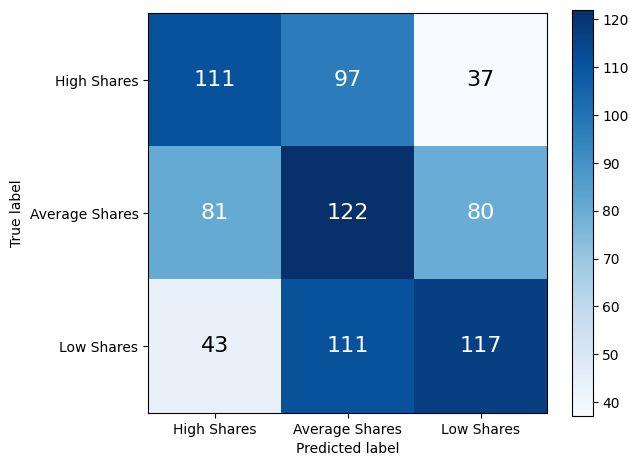

In [39]:
y_pred_cnn = cnn_model.predict(X_test_map)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
y_pred_cnn = np.vectorize(lambda x: rev_mapper[x])(y_pred_cnn)

y_test_cnn = np.argmax(y_test_encode, axis=1)
y_test_cnn = np.vectorize(lambda x: rev_mapper[x])(y_test_cnn)

evaluate_model(y_test_cnn, y_pred_cnn)